In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy
from textacy.extract import keyword_in_context

from collections import Counter

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pyLDAvis.sklearn

import warnings
warnings.filterwarnings("ignore")

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()

# Import data set:

In [2]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

## Keep cases marked as Unknown Homeland (Ukendt hjemland):

In [3]:
df_ALL = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_ALL[['text']]

df["text"] = df["text"].astype(str)

df.shape

#df.head()


(192, 1)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [4]:
df['length'] = df['text'].str.len()

df.describe().T

count         mean         std     min     25%     50%      75%  \
length  192.0  5016.598958  2045.83413  1104.0  3522.0  4789.0  6148.75   

            max  
length  13105.0

## Boxplot:

<AxesSubplot:>

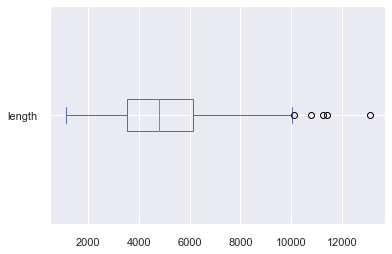

In [5]:
# Box plot:
df['length'].plot(kind='box', vert=False)

## Histogram:

<AxesSubplot:ylabel='Frequency'>

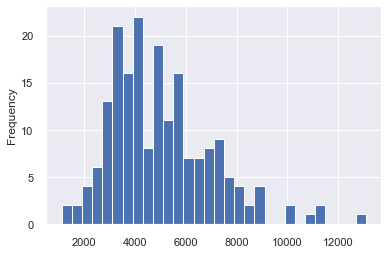

In [6]:
# Histogram:
df['length'].plot(kind='hist', bins=30)


# Create a pipeline:

Below are the steps taken to process the texts.

In [7]:
stopwords_lower = list(map(lambda x: x.lower(), stopwords.words('danish')))

STOPWORDS_DANISH = set(stopwords_lower)

nlp = spacy.load("da_core_news_sm")

PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


def remove_stopwords(tokens):
    """custom function to remove stopwords"""
    return [t for t in tokens if t.lower() not in STOPWORDS_DANISH]


def tokenize(text):
    """the following expression matches tokens consisting of at least one letter (\p{L}), 
    preceded and followed by an arbitrary sequence of alphanumeric characters 
    (\w includes digits, letters, and underscore) and hyphens (-)"""
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


def drop_single_letter_words(text):
    return [w for w in text if len(w) > 1]


def lemmatize(text):
    """custom function to lemmatize text"""
    doc = nlp(' '.join(text))
    # pos_tagged_text = text.pos
    return [token.lemma_ for token in doc]


# def remove_junk(text):
#     # Creating a spacy object
#     doc = nlp(' '.join(text))
#     # Checking if POS tag is X and printing them
#     for token in doc:
#         if token.pos_ == 'X':
#             print(token.text)
#     # Removing the tokens whose POS tag is junk.
#     clean_doc = [token.text for token in doc if not token.pos_ == 'X']

#     return clean_doc


Steps can be added or removed from the pipeline.

In [8]:
pipeline = [str.lower, remove_punctuation, tokenize,
            drop_single_letter_words, remove_stopwords, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [9]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [10]:
df.head()

text  length  \
201           Nævnet stadfæstede i november 2021 Udl...    4753   
428           Nævnet stadfæstede i juni 2021 Udlændi...    3149   
464           Nævnet stadfæstede i juni 2021 Udlændi...    4433   
901           Nævnet stadfæstede i december 2020 Udl...    2664   
1291          Nævnet hjemviste i juni 2020 Udlænding...    4626   

                                                 tokens  num_tokens  
201   [nævn, stadfæste, november, udlændingestyrelse...         373  
428   [nævn, stadfæste, juni, udlændingestyrelse, af...         243  
464   [nævn, stadfæste, juni, udlændingestyrelse, af...         350  
901   [nævn, stadfæste, december, udlændingestyrelse...         207  
1291  [nævn, hjemviste, juni, udlændingestyrelse, af...         354

# Frequency analysis:

Here we count the most frequent tokens in the **whole** corpus.


In [11]:
# Transform the counter into a Pandas DataFrame with the following function:

"""
The tokens make up the index of the DataFrame, while the frequency values are stored in a column named freq. 
The rows are sorted so that the most frequent words appear at the head.
The last parameter of count_words defines a minimum frequency of tokens to be included in the result. 
Its default is set to 2 to cut down on tokens occurring only once.
"""

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    # create counter and run through all data
    counter = Counter() 
    df[column].map(update)
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [12]:
# See ten most frequent words in the whole corpus:

freq_df = count_words(df) 
freq_df.head(10)

freq
token               
ansøger         4889
flygtningenævn  1510
kuwait          1453
forklare        1252
oplyse           845
ansøge           838
vide             823
myndighed        817
mandlig          807
demonstration    745

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

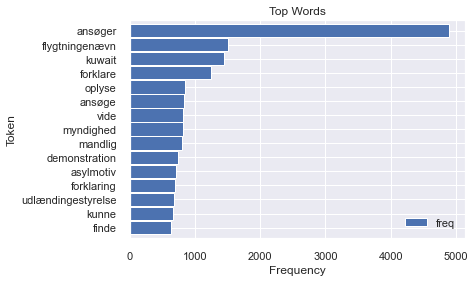

In [13]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95) 
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# TF-IDF Ranking:

Rank tokens based on their TF-IDF score.

In [14]:
"""
Each token is counted only once per document (counter.update(set(tokens))), 
and the IDF values are computed after counting. 
The parameter min_df serves as a filter for the long tail of infrequent words. 
The result of this function is a DataFrame.
"""

def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc) 
        counter.update(set(tokens))
        # count tokens
    counter = Counter() 
    df[column].map(update)
        # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df']) 
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [15]:
# Create a DataFrame containing the IDF values for each token (idf_df):

idf_df = compute_idf(df)

# Both the IDF and the frequency DataFrame have an index consisting of the tokens, 
# we can simply multiply the columns of both DataFrames to calculate the TF-IDF score for the terms:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']


In [16]:
# Sort values based on their score:
freq_df = freq_df.sort_values('tfidf', ascending=False)

# See the top 15:
freq_df.head(15)

freq        tfidf
token                           
klager          344  1050.889136
ansøger        4889   750.406181
ansøge          838   622.110129
kuwait         1453   523.491342
demonstration   745   449.909360
kvindelig       358   358.281583
ægtefælle       313   347.117041
eritrea         107   307.366993
forklare       1252   299.855953
bror            285   281.593543
mandlig         807   269.227185
deltage         409   246.997219
far             274   238.067367
familie         505   228.371400
bopæl           382   224.161706

[Text(0.5, 0, 'Weights'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top 15 Words based on TF-IDF Ranking')]

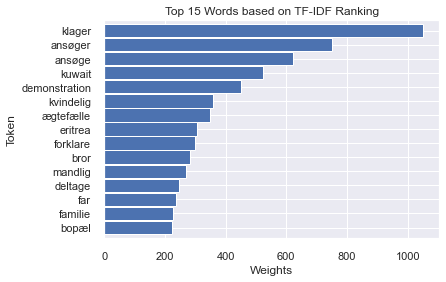

In [17]:
# Plot the results:
ax_tf_idf = freq_df['tfidf'].head(15).plot(kind='barh', width=0.95) 
ax_tf_idf.invert_yaxis()
ax_tf_idf.set(xlabel='Weights', ylabel='Token', title='Top 15 Words based on TF-IDF Ranking')

# Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.

In [18]:
"""
The function iteratively collects the keyword contexts by applying the add_kwic function to each document with map. 
By default, the function returns a list of tuples of the form (left context, keyword, right context). 
If print_samples is greater than 0, a random sample of the results is printed. 
Sampling is especially useful with lots of documents because the first entries of the list 
would otherwise stem from a single or a very small number of documents.
"""

def kwic(doc_series, keyword, window=35, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f'{k} random samples out of {len(kwic_list)} ' +
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' +
                  sample[1]+' ' +
                  re.sub(r'[\n\t]', ' ', sample[2]))


Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.

In [19]:
kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 380 contexts for 'stk':
adelse efter udlændingelovens § 7,  stk . 1, eller stk. 2, er opfyldt. Flyg
 omfattet af udlændingelovens § 7,  stk . 1 eller stk. 2. Flygtnin-genævnet
 fremgår af udlændingelovens § 54,  stk . 1, at Flygtningenævnet drager oms
ingelovens § 11, stk. 2, jf. § 19,  stk . 2, nr. 1, og § 19 a, stk. 1, jf. 
adelse efter udlændingelovens § 7,  stk . 1 eller stk. 2, er opfyldt. Flygt
f. § 19, stk. 2, nr. 1, og § 19 a,  stk . 1, jf. § 26, stk. 1, er opfyldt, 
 omfattet af udlændingelovens § 7,  stk . 1 eller 2, og Flygtningenævnet st
ingenævnets forretningsorden § 36,  stk . 1, 1. pkt. Ansøgerne er efter det
 omfattet af udlændingelovens § 7,  stk . 1 eller stk. 2. Flygtningenævnet 
i udlændingelovens § 7, stk. 1, og  stk . 2, er herefter ikke opfyldt. Flyg


# N-gram analysis:

In [20]:
"""
Create the bigrams on all tokens but keep only those that do not contain any stop words.
"""

def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) 
            if len([t for t in ngram if t in stopwords]) == 0]


Add a column to the dataset containing all 'bigrams'.

Then apply `count_words` in order to determing the 10 most popular ones.

In [21]:
df['bigrams'] = df['text'].apply(process, pipeline=pipeline).apply(ngrams, n=2, stopwords=STOPWORDS_DANISH)

count_words(df, 'bigrams').head(10)

freq
token                             
mandlig ansøge                 523
udlændingestyrelse afgørelse   408
ansøger forklaring             376
vide tilbagevenden             332
kvindelig ansøge               291
lægge vægt                     289
ansøger forklare               281
deltage demonstration          264
flygtningenævn finde           250
kuwait ansøger                 249

# Topic Modelling:

## NMF:

In [25]:
df['joined_tokens'] = df['tokens'].apply(', '.join)

tfidf_text = TfidfVectorizer(stop_words = STOPWORDS_DANISH, min_df = 5, max_df = 0.7)
vectors_text = tfidf_text.fit_transform(df['joined_tokens'])
vectors_text.shape

(192, 1081)

In [26]:
nmf_text_model = NMF(n_components=10, random_state=42)

W_text_matrix = nmf_text_model.fit_transform(vectors_text)
H_text_matrix = nmf_text_model.components_

def display_topics(model, features, num_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # inverts sort order
        print("\nTopic %02d" % topic)
        for i in range(0, num_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

Display topics:

Presenting topics, along with words and percentages with which the words contribute to each of the topic.

In [27]:
display_topics(nmf_text_model, tfidf_text.get_feature_names_out())


Topic 00
 demonstration (4.14)
 deltage (2.36)
 tilbageholde (1.19)
 rettighed (1.06)
 bidooners (1.01)

Topic 01
 klager (19.98)
 jf (1.96)
 opholdstilladelse (1.92)
 nr (1.55)
 svig (1.52)

Topic 02
 ansøge (8.33)
 kvindelig (3.44)
 demonstration (1.21)
 bidoonere (0.95)
 dag (0.91)

Topic 03
 ansøge (2.07)
 kvindelig (1.79)
 demonstration (1.49)
 bære (1.47)
 videre (1.32)

Topic 04
 eritrea (8.89)
 sudan (4.08)
 etiopien (2.04)
 tigrinya (1.60)
 eritreiske (1.35)

Topic 05
 barn (1.61)
 søn (1.32)
 demonstration (1.17)
 følge (1.10)
 farbror (1.08)

Topic 06
 dato (1.86)
 nær (1.69)
 angive (1.65)
 sommer (1.13)
 forældre (1.13)

Topic 07
 bror (4.42)
 udlænding (1.45)
 far (1.34)
 divergere (1.30)
 følge (0.84)

Topic 08
 ægtefælle (8.07)
 barn (1.46)
 bopæl (1.18)
 gang (0.88)
 side (0.81)

Topic 09
 far (1.83)
 mand (1.30)
 seksuel (1.00)
 slå (0.96)
 ihjel (0.81)


See how many documents could be assigned mainly to each topic: 

- Calculate using the document - topic matrix and summing the individual topic contributions over all documents.

Normalizing them with the total sum and multiplying by 100 gives a percentage value:

In [28]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.34573117,  5.86689171, 11.61104777,  6.9022    ,  5.76586364,
        7.47238027, 12.40042488, 13.00833123,  8.79783889, 16.82929044])

## Latent Semantic Analysis/Indexing:

Similar analysis to NMF but using a different algorithm: Singular Value Decomposition (SVD).

In [29]:
svd_model = TruncatedSVD(n_components=10, random_state=42)

W_svd_text_matrix = svd_model.fit_transform(vectors_text)
H_svd_text_matrix = svd_model.components_

In [30]:
display_topics(svd_model, tfidf_text.get_feature_names_out())


Topic 00
 ansøge (1.52)
 demonstration (1.30)
 kvindelig (0.73)
 deltage (0.72)
 bopæl (0.60)

Topic 01
 klager (21.75)
 eritrea (2.61)
 jf (2.36)
 opholdstilladelse (2.34)
 bror (1.75)

Topic 02
 ansøge (-9.11)
 klager (-5.97)
 kvindelig (-4.83)
 demonstration (-1.49)
 bære (-1.28)

Topic 03
 eritrea (15.14)
 sudan (7.18)
 nævnsmøde (5.12)
 år (4.53)
 bære (4.39)

Topic 04
 eritrea (-1474.38)
 ansøge (-958.34)
 sudan (-652.33)
 etiopien (-346.37)
 tigrinya (-267.92)

Topic 05
 demonstration (78.71)
 eritrea (68.90)
 deltage (36.22)
 sudan (32.01)
 fald (22.40)

Topic 06
 ægtefælle (16.44)
 barn (12.82)
 søn (8.46)
 forskellig (6.19)
 bidoonere (5.74)

Topic 07
 bror (545.58)
 udlænding (305.31)
 ansøge (245.05)
 opholdstilladelse (185.93)
 bidoonere (183.09)

Topic 08
 ægtefælle (-16.56)
 eritrea (-6.69)
 bror (-5.62)
 udlænding (-4.10)
 bopæl (-3.96)

Topic 09
 bror (-11.19)
 ægtefælle (-7.76)
 mor (-5.38)
 begyndelse (-5.36)
 hjemland (-5.18)


The results are pretty much the same as with NMF. 

The main difference is that SVD allows for negative values. This means that contributions of individual words can be negative.

SVD therefore can present words in documents which "reject" the corresponding topic.

# Latent Dirichlet Allocation:

In [31]:
count_text_vectorizer = CountVectorizer(stop_words=STOPWORDS_DANISH, min_df=2, max_df=0.7)

count_text_vectors = count_text_vectorizer.fit_transform(df['joined_tokens'])

lda_text_model = LatentDirichletAllocation(n_components=10, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 dag (1.24)
 far (1.19)
 bror (1.17)
 divergere (1.11)
 demonstration (1.01)

Topic 01
 forældre (2.51)
 bo (2.19)
 start (1.27)
 danmark (1.25)
 mand (1.00)

Topic 02
 klager (8.28)
 opholdstilladelse (2.36)
 jf (1.47)
 danmark (1.27)
 efterår (0.94)

Topic 03
 demonstration (1.96)
 bidoon (1.53)
 følge (1.48)
 barn (1.29)
 navn (1.19)

Topic 04
 mor (2.45)
 mand (1.89)
 gang (1.77)
 bopæl (1.37)
 dag (1.32)

Topic 05
 far (2.18)
 ægtefælle (1.40)
 mor (1.20)
 slå (1.09)
 år (0.93)

Topic 06
 bopæl (1.53)
 ægtefælle (1.52)
 demonstration (1.42)
 dag (1.17)
 deltage (1.03)

Topic 07
 ansøge (5.81)
 demonstration (3.16)
 kvindelig (2.40)
 deltage (1.45)
 bopæl (1.01)

Topic 08
 myanmar (1.44)
 føde (1.35)
 år (1.25)
 bo (1.24)
 statsborger (1.14)

Topic 09
 eritrea (3.70)
 sudan (1.85)
 etiopien (1.48)
 statsborger (0.95)
 flygte (0.93)


Visualise the topics produced by LDA:

In [32]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(lda_display)

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# Visualizations:

In [33]:
from wordcloud import WordCloud

def wordcloud_topics (model, features, no_top_words=40):
    for topics, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # inverts order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')

WordCloud for the NMF topic modelling:

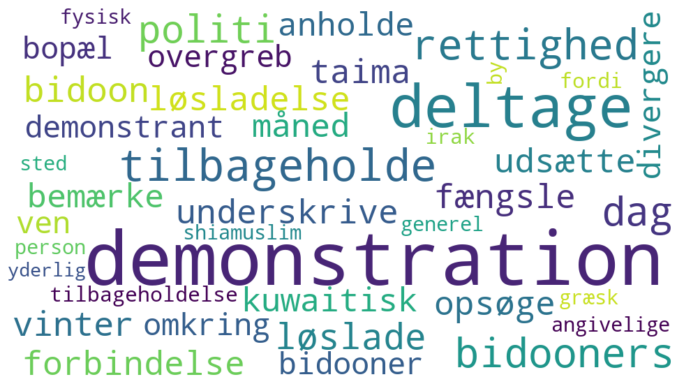

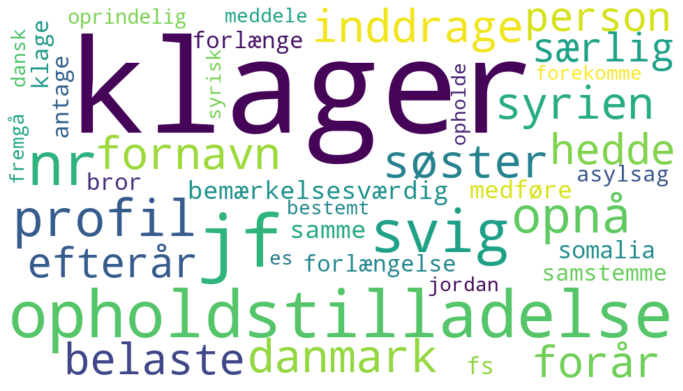

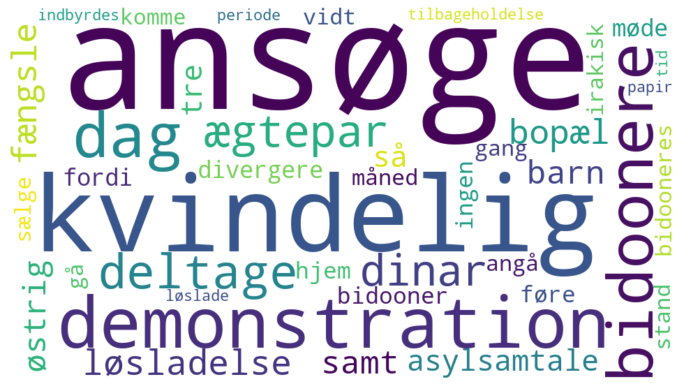

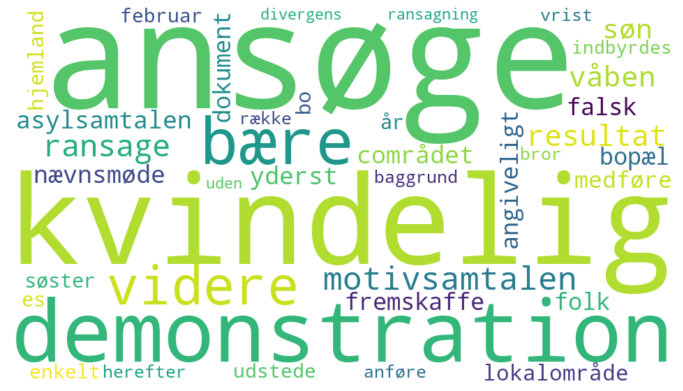

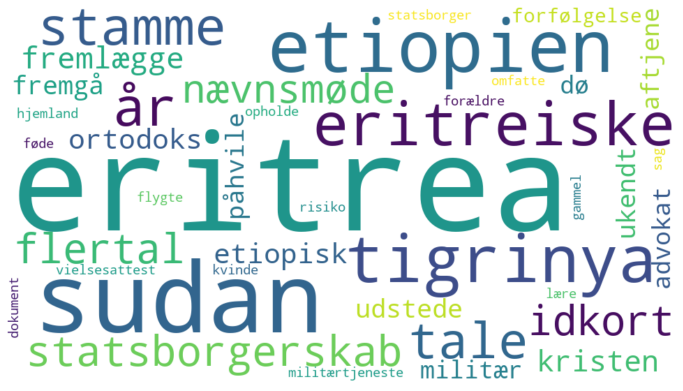

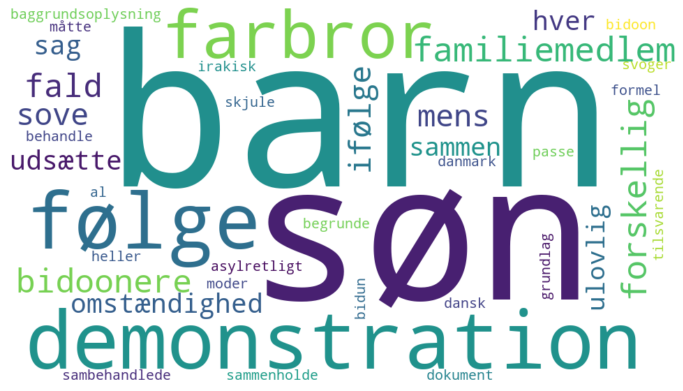

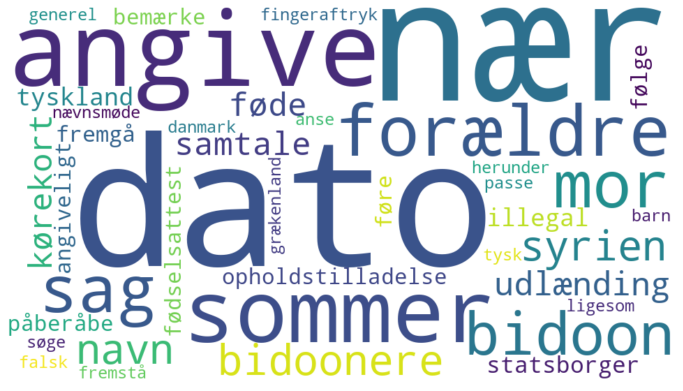

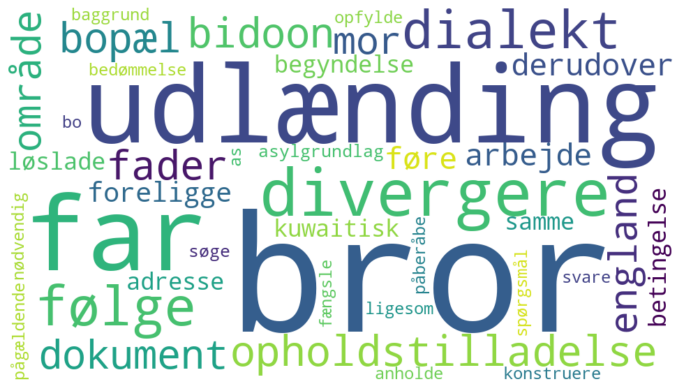

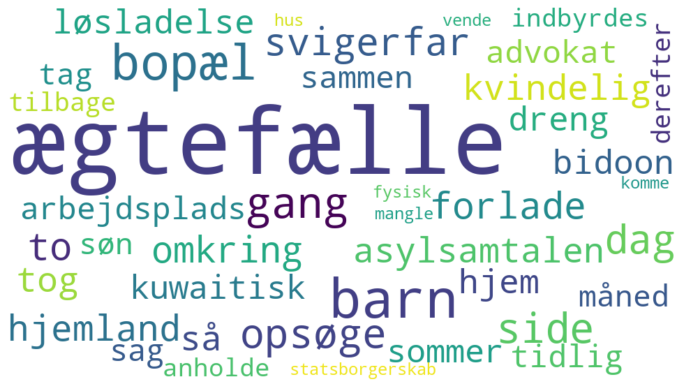

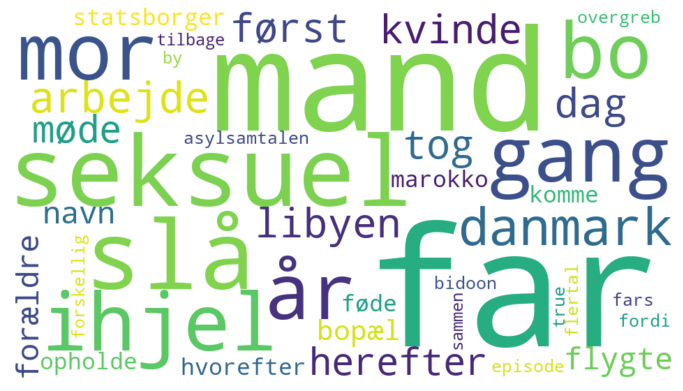

In [34]:
wordcloud_topics(nmf_text_model, tfidf_text.get_feature_names_out())

WordCloud for the LDA topic modelling:

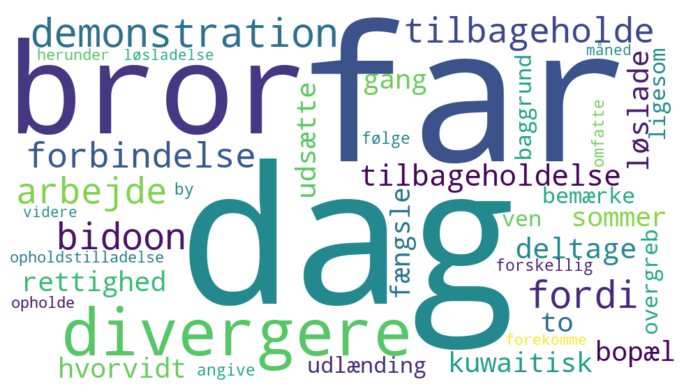

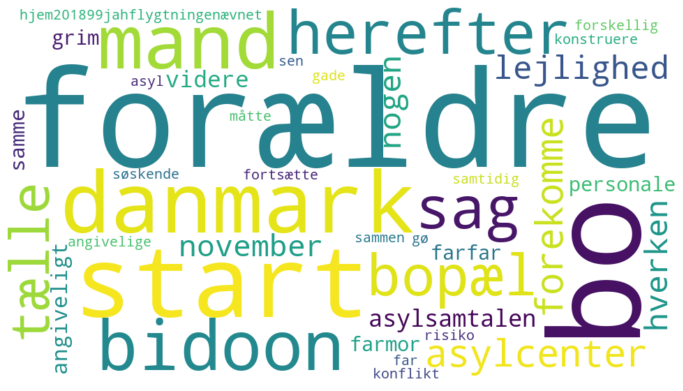

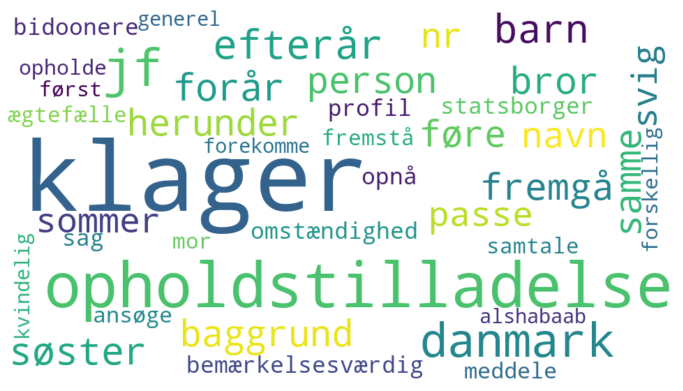

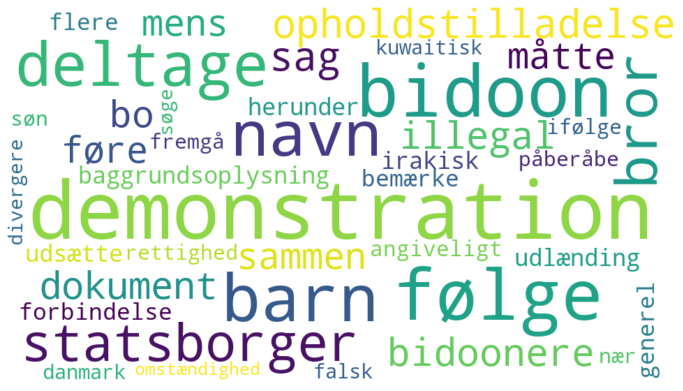

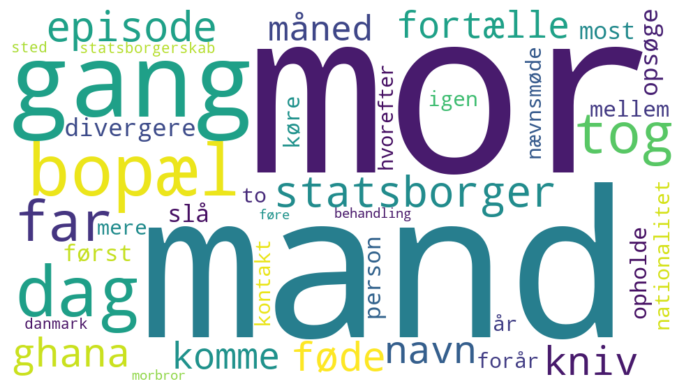

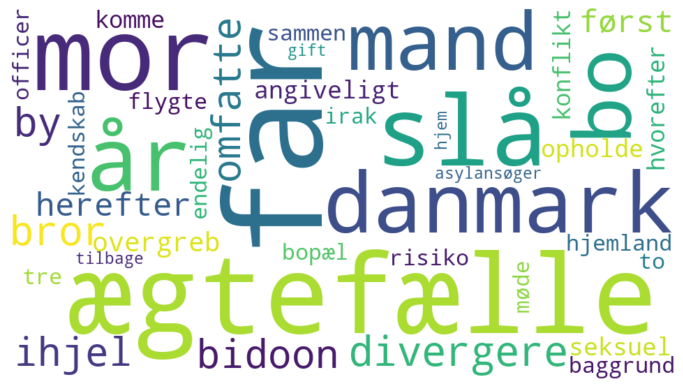

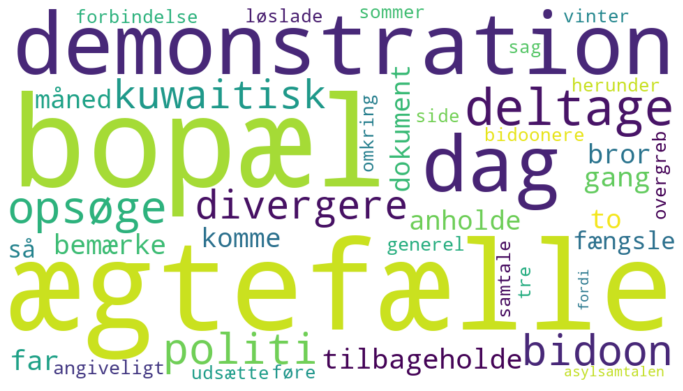

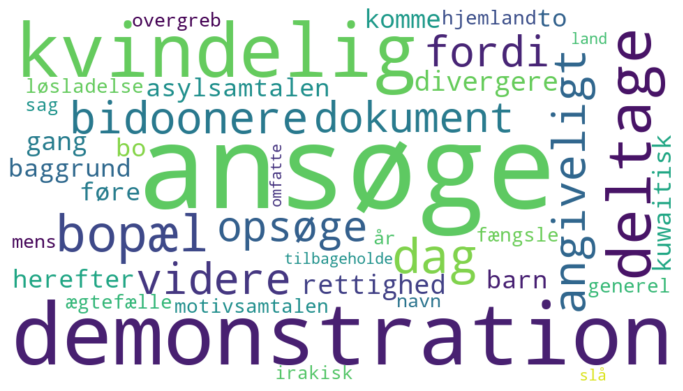

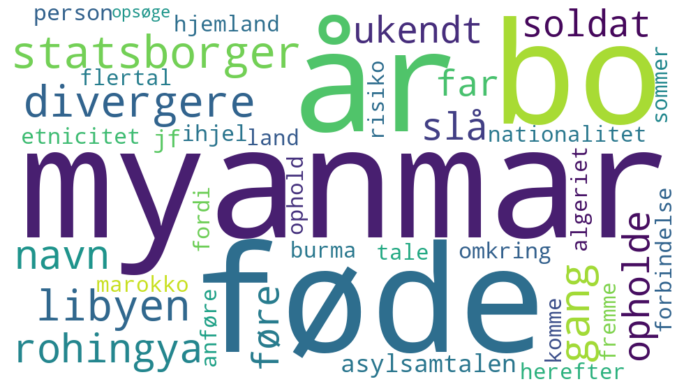

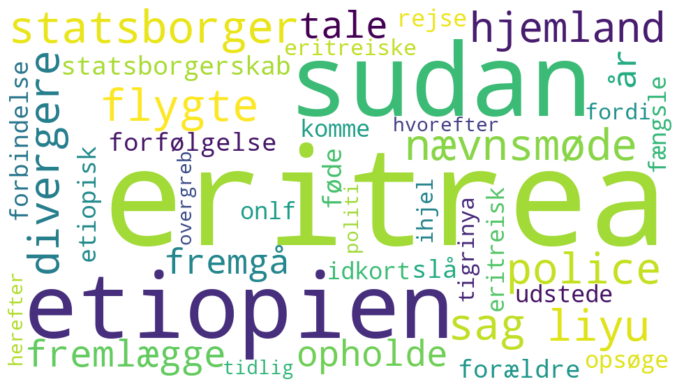

In [35]:
wordcloud_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())